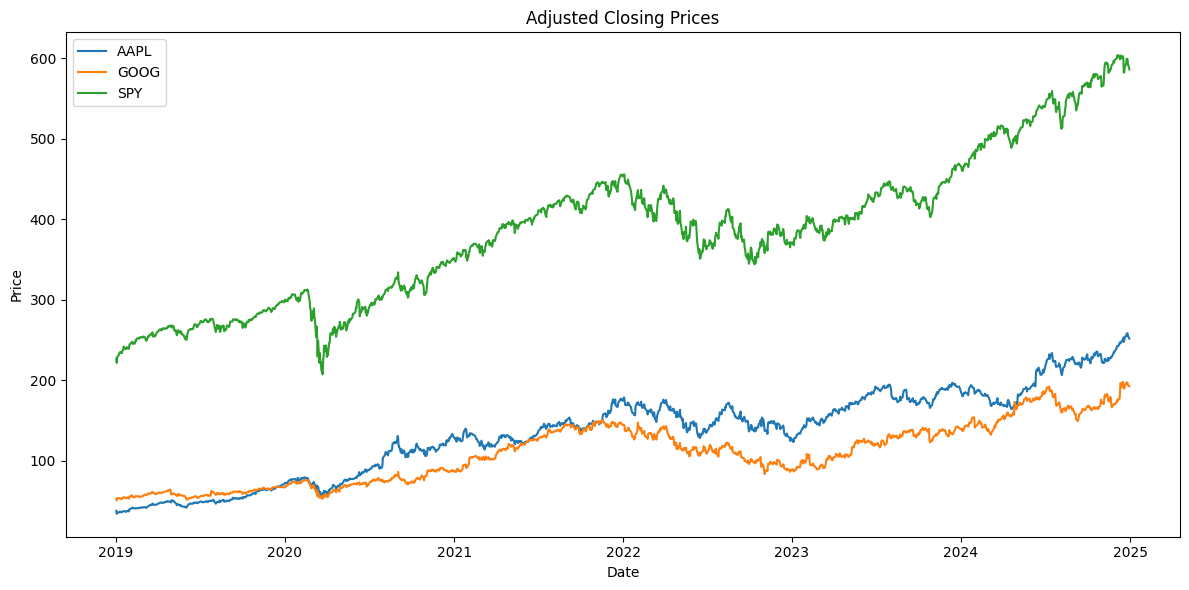

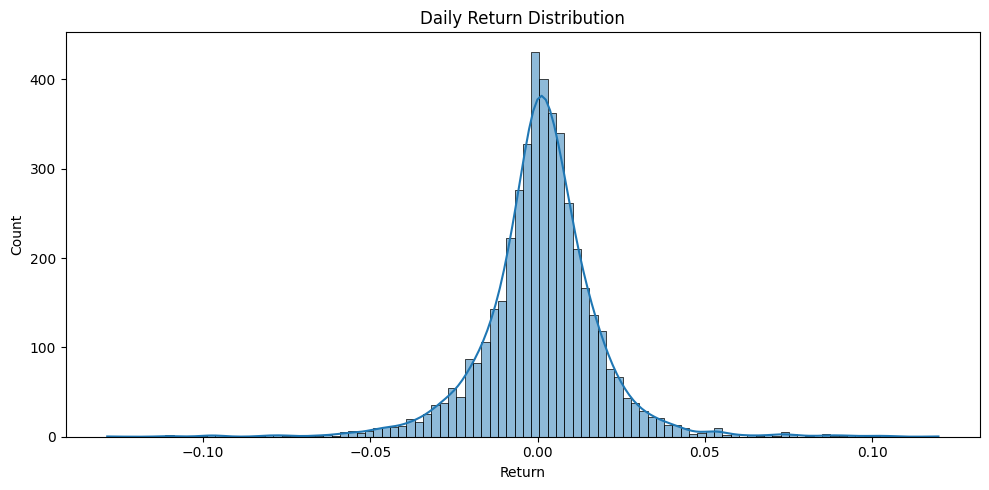

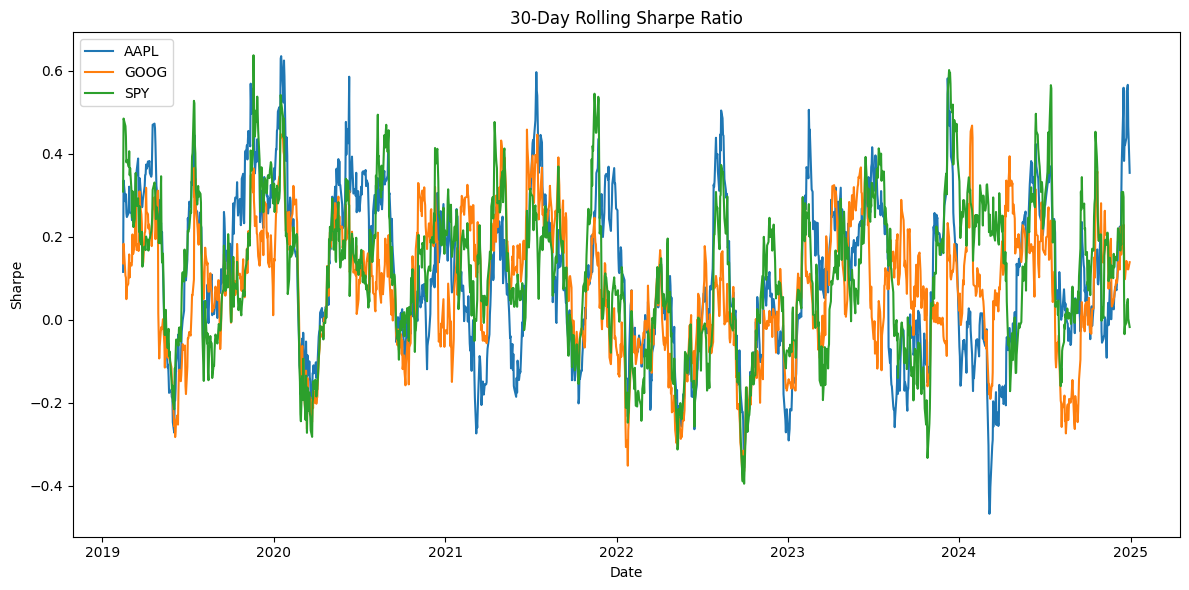

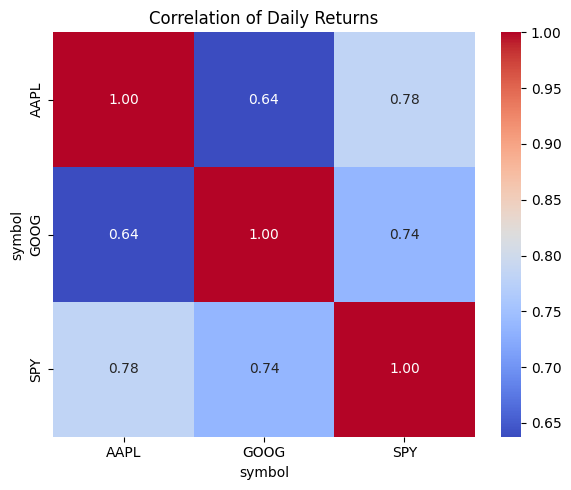

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob

# Paths
RAW_PATH = "../data/raw/"
PROCESSED_PATH = "../data/processed/"
REPORTS_PATH = "../outputs/reports/"
os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# Load and clean all CSVs
csv_files = glob.glob(os.path.join(RAW_PATH, "*.csv"))
dfs = []

for file in csv_files:
    df = pd.read_csv(file, parse_dates=["Date"])
    symbol = os.path.basename(file).split("_")[0]
    df["symbol"] = symbol

    # Use 'Adj Close' or fallback to 'Close'
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df = df.dropna(subset=[price_col])
    df["Price"] = df[price_col]

    dfs.append(df)

if not dfs:
    raise ValueError("❌ No valid CSVs found in /data/raw/")

combined = pd.concat(dfs).sort_values(["symbol", "Date"]).reset_index(drop=True)

# Compute daily returns
combined["Return"] = combined.groupby("symbol")["Price"].transform(lambda x: x.pct_change(fill_method=None))
combined["Rolling Volatility"] = combined.groupby("symbol")["Return"].transform(lambda x: x.rolling(30).std())
combined["Rolling Sharpe"] = combined.groupby("symbol")["Return"].transform(lambda x: x.rolling(30).mean()) / combined["Rolling Volatility"]

# Save processed data
combined.to_csv(os.path.join(PROCESSED_PATH, "returns_combined.csv"), index=False)

# ===================== VISUALS =====================
# 1. Line plot: Adjusted price
plt.figure(figsize=(12, 6))
for sym in combined["symbol"].unique():
    plt.plot(combined[combined["symbol"] == sym]["Date"],
             combined[combined["symbol"] == sym]["Price"], label=sym)
plt.title("Adjusted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, "price_chart.png"))
plt.show()

# 2. Histogram of returns
plt.figure(figsize=(10, 5))
sns.histplot(combined["Return"].dropna(), bins=100, kde=True)
plt.title("Daily Return Distribution")
plt.xlabel("Return")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, "return_histogram.png"))
plt.show()

# 3. Rolling Sharpe
plt.figure(figsize=(12, 6))
for sym in combined["symbol"].unique():
    plt.plot(combined[combined["symbol"] == sym]["Date"],
             combined[combined["symbol"] == sym]["Rolling Sharpe"], label=sym)
plt.title("30-Day Rolling Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, "rolling_sharpe.png"))
plt.show()

# 4. Correlation heatmap
corr = combined.pivot(index="Date", columns="symbol", values="Return").corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Daily Returns")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, "correlation_heatmap.png"))
plt.show()